In [538]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

df = get_data_index("r1") # all RAM subjects
HPC_labels = [MTL_labels[i] for i in [0,1,2,3,4,8,9,10,11,12,20,24,25]] # all labels within HPC

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [539]:
exp = 'FR1'
poss_subs = df[df.experiment == exp]

In [561]:
# for now, get an example subject's FR data
# subs = ['R1112M','R1163T'] #'R1112M' # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
subs = ['R1001P','R1002P','R1003P','R1006P','R1010J','R1112M','R1163T']
# subs = ['R1010J','R1112M'] # original 2
# sess = 2
sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # & (df.session == sess)]
# sub_df = sub_df[1:4]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
1,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
18,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,1,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
25,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...,protocols/r1/subjects/R1006P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1006P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1006P/localizations/0/m...,NaN,0,R1006P,R1006P,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...
26,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...,protocols/r1/subjects/R1006P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1006P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1006P/localizations/0/m...,NaN,1,R1006P,R1006P,NaN,protocols/r1/subjects/R1006P/experiments/FR1/s...
37,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...,protocols/r1/subjects/R1010J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1010J/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1010J/localizations/0/m...,NaN,0,R1010J,R1010J,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...
38,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...,protocols/r1/subjects/R1010J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1010J/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1010J/localizations/0/m...,NaN,1,R1010J,R1010J,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...


## Get raw, 80-120 Hz, and 250-500 Hz eeg and detect ripples!

In [613]:
import mne
from ptsa.data.filters import ButterworthFilter
from scipy.signal import firwin,filtfilt
%matplotlib inline
from pylab import *
%autoreload

save_values = 1
filter_type = 'hamming' # 'butter'#'hamming' # Vaz used Butterworth from 80-120 Hz; Norman used Hamming from 70-180 Hz
# •Butterworth from Vaz et al: 2nd order from 80-120 ms, hilbert, select events >2 STD above mean of filtered traces.
#      Events >=25 ms long w/ max amp >3 SD were retained as ripples. Join adjacent ripples separated by <15 ms 
# •Hilbert from Norman et al: "70-180 Hz zero-lag linear-phase Hamming FIR filter w/ transition bandwidth of 5 Hz"
#      Then Hilbert, clip extreme to 4 SD, square this clipped, smooth w/ Kaiser FIR low-pass filter with 40 Hz cutoff,
#      mean and SD computed across entire experimental duration to define the threshold for event detection
#      Events from original (squared but unclipped) signal >4 SD above baseline were selected as candidate SWR events. 
#      Duration expanded until ripple power <2 SD. Events <20 ms or >200 ms excluded. Adjacent events <30 ms separation (peak-to-peak) merged.
# •Using IED detection from Vaz for 250 Hz highpass events (really 250-499). Norman uses 20-60 Hz events which is...odd.
#       See detectRipples code in module for this algorithm

IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
start = -IRI # only makes sense to look at period <= IRI
end = 2000 # how long to grab data after recall

# FIR filter a la Norman et al
desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
trans_width = 5.
ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(desired_sample_rate/trans_width) # gives 400 with sr=500, trans=5
FIR_bandstop = firwin(int(ntaps+1), [70.,180.], fs=desired_sample_rate, window='hamming',pass_zero='bandstop')

# FIR lowpass 40 hz filter for Malach dtection algo
nyquist = sr/2
ntaps40, beta40 = kaiserord(40, trans_width/nyquist)
kaiser_40lp_filter = firwin(ntaps40, cutoff=40, window=('kaiser', beta40), scale=False, nyq=nyquist, pass_zero='lowpass')

ripple_array = []; trial_nums = []; ripple_mstime_array = []
session_ct = 0; channel_ct = 0
HPC_names = []; sub_names = []; sub_sess_names = []
electrodes_per_session = []
total_lists = 0; total_recalls = 0; kept_recalls = 0
for row in sub_df.itertuples():    
    sub = row.subject; session = row.session; exp = row.experiment
    mont = int(row.montage); loc = int(row.localization)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    evs_free_recall = evs[evs.type=='REC_WORD']
    total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
    total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
    # remove events with Inter-Recall Intervals too small. Use start time since that's what will show in PSTH
    evs_free_recall = evs_free_recall[np.append(True,np.diff(evs_free_recall.mstime)>IRI)] #abs(start))]
    kept_recalls = kept_recalls + len(evs_free_recall)
    pairs = reader.load('pairs')
    tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
    elec_regions,_ = get_elec_regions(tal_struct) 
    
    eeg = reader.load_eeg(events=evs_free_recall, rel_start=start, rel_stop=end, clean=True, scheme=pairs)
    # events X electrodes X time
    eeg_ptsa = eeg.to_ptsa()
    sr = eeg.samplerate
    if np.mod(sr,1)>0: # if not an integer, there are issues, so skip
        continue
    else:
        sr = int(sr)
        print('Sampling rate: '+str(sr))
    
    # filter using filter selected above
    if filter_type == 'butter':
        eeg_rip_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
    elif filter_type == 'hamming':
        eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop,1.,eeg_ptsa) # need to subtract out to get the filtered signal since default is bandstop (I think)
    if sr == 500: # 500 is half the sr so go to 499
        # Vaz used 250 HP, but since I'm at Nyquist of 250, need to drop a bit below to detect anything (249 sees nothing)
        eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=200., filt_type='highpass',order=2).filter() # Vaz used 250, but since I'm at 
    elif sr >= 1000:    
        # this seems okay since large range far from Nyquist...shold check though
        import ipdb; ipdb.set_trace()
        eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[250.,499.], filt_type='bandpass',order=2).filter()
    else:
        eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=250., filt_type='highpass',order=2).filter()
    
    eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,end-start])
    _ = eeg_rip_band.apply_hilbert(envelope=True)
    eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,end-start])
    _ = eeg_ied_band.apply_hilbert(envelope=True)
    eeg_raw = ptsa_to_mne(eeg_ptsa,[0,end-start])    

    HPC_elecs_ct = 0
    for channel in range(len(elec_regions)):
        if elec_regions[channel] in HPC_labels:
            channel_ct+=1  
            HPC_elecs_ct+=1
            HPC_names.append(elec_regions[channel])
            sub_names.append(sub)
            sub_sess_names.append(sub+'-'+str(session))
            eeg_rip = eeg_rip_band.get_data()[:,channel,:] # get data from MNE container
            eeg_ied = eeg_ied_band.get_data()[:,channel,:]
            eeg_mne = eeg_raw.get_data()[:,channel,:]
            
            # select detection algorithm
            temp_ripplelogic, iedlogic = detectRipplesButter(eeg_rip,eeg_ied,eeg_mne,sr)
            if filter_type == 'butter':
                ripplelogic = temp_ripplelogic 
#      Then Hilbert, clip extreme to 4 SD, square this clipped, smooth w/ Kaiser FIR low-pass filter with 40 Hz cutoff,
#      mean and SD computed across entire experimental duration to define the threshold for event detection
#      Events from original (squared but unclipped) signal >4 SD above baseline were selected as candidate SWR events. 
#      Duration expanded until ripple power <2 SD. Events <20 ms or >200 ms excluded. Adjacent events <30 ms separation (peak-to-peak) merged.
            elif filter_type == 'hamming':
                orig_eeg_rip = copy(eeg_rip)
                clip_SD = 4*np.std(eeg_rip)
                eeg_rip[eeg_rip>clip_SD] = clip_SD # clip at 4SD
                eeg_rip = eeg_rip**2 # square
                eeg_rip = filtfilt(kaiser_40lp_filter,1.,eeg_rip)
                mean_detection_thresh = np.mean(eeg_rip)
                std_detection_thresh = np.std(eeg_rip)
                # now, find candidate events and find >2SD periods around those events
                ripplelogic = orig_eeg_rip**2>=(mean_detection_thresh+4*std_detection_thresh)
                import ipdb; ipdb.set_trace()
                ripplelogic[iedlogic==1] = 0 # remove IEDs detected from Vaz algo
                num_trials = ripplelogic.shape[0]
                for trial in range(num_trials):
                    ripplelogictrial = ripplelogic[trial]
                    starts,ends = getLogicalChunks(ripplelogictrial)
                
                
#                 ripplelogic, iedlogic = detectRipplesHamming(eeg_rip,eeg_ied,eeg_mne,sr)
            
            # have to make a decision on upsampling v. downsampling since there are diff. sampling rates
            if sr>desired_sample_rate: # downsampling here for anything greater than 500...will be issues if SR not divisible
                # but can fix that in the future if necessary (I think I would need to up then downsample)
                ripplelogic = downsampleBinary(ripplelogic,sr/500)
                iedlogic = downsampleBinary(iedlogic,sr/500)
            ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
            print('Cumulative array size: ')
            print(ripple_array.shape)
            trial_nums = np.append(trial_nums,ripplelogic.shape[0])
    electrodes_per_session = np.append(electrodes_per_session,HPC_elecs_ct)
    session_ct+=1   

fn = os.path.join('/home1/john/SWR/',
    'SWR_array_from-'+str(session_ct)+'_sessions_in-'+str(len(np.unique(sub_names)))+'subjects_'+filter_type+'.p')            
with open(fn,'wb') as f:
    pickle.dump({'ripple_array':ripple_array, 'session_ct':session_ct,
                'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                'channel_ct':channel_ct}, f)

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1001P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1001P/tal/R1001P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1001P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)


Sampling rate: 500
70 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
70 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
70 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
--Call--
> /home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/IPython/core/displayhook.py(252)__call__()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.



ipdb>  u


> <ipython-input-613-086b5b4cb227>(116)<module>()
    115                 ripplelogic = orig_eeg_rip**2>=(mean_detection_thresh+4*std_detection_thresh)
--> 116                 import ipdb; ipdb.set_trace()
    117                 ripplelogic[iedlogic==1] = 0



ipdb>  sum(iedlogic)


102


ipdb>  q


BdbQuit: 

In [617]:
starts
ends

[470,
 543,
 1139,
 1144,
 1155,
 1161,
 1250,
 1318,
 1613,
 1742,
 1762,
 1902,
 1990,
 1997,
 1997]

[471,
 544,
 1141,
 1145,
 1157,
 1162,
 1252,
 1321,
 1613,
 1742,
 1763,
 1906,
 1992,
 1998,
 1998]

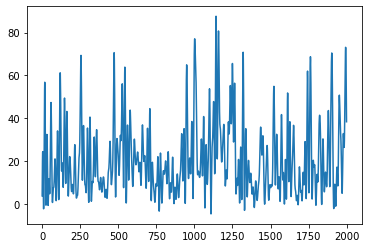

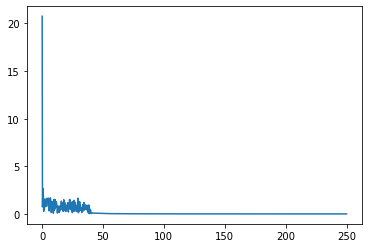

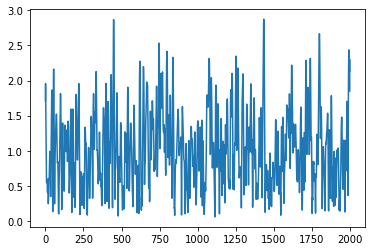

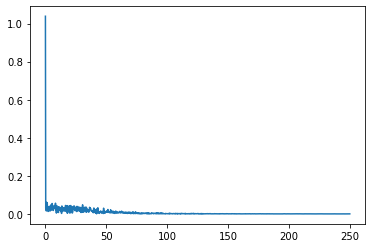

In [609]:
plt.plot(eeg_rip[0]); plt.show()
plt.plot(xr,normFFT(eeg_rip[0])); plt.show()
plt.plot(eeg_ied_band.get_data()[:,channel,:][0]); plt.show()
plt.plot(xr,normFFT(eeg_ied_band.get_data()[:,channel,:][0])); plt.show()

## Example implementations of various filters being used

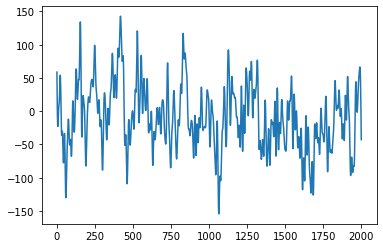

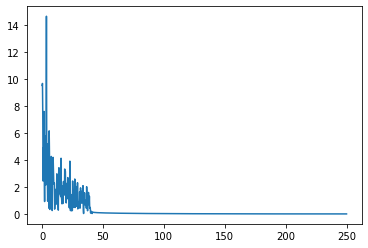

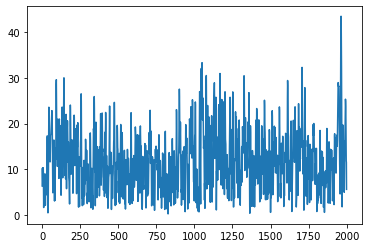

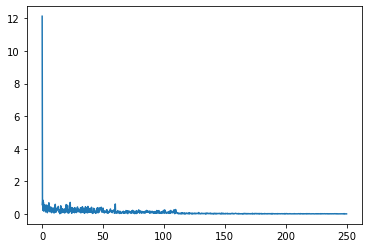

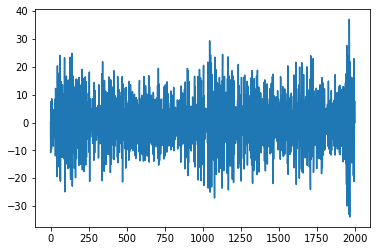

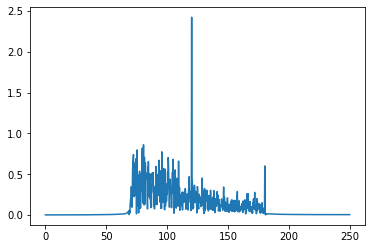

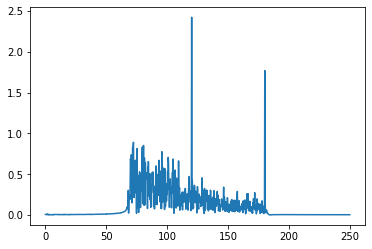

In [590]:
from scipy.signal import kaiserord,firwin
from scipy import fft

FIR_bandpass = firwin(int(ntaps+1), [70.,180.], fs=desired_sample_rate, window='hamming',pass_zero='bandpass')
FIR_bandstop = firwin(int(ntaps), [70.,180.], fs=desired_sample_rate, window='hamming')

N = len(filt_eeg)
xr = np.linspace(0,NN/(4000/sr),NN/2) # 4000 ms of data/500 Hz sampling

## WHAT IS WRONG WITH EEG_RIP?? Nothing! Just hilbert+rectification ruins the bandpass in the FFT

# plot FFT of kaiser 40 hz lowpass
temp_rip = eeg_ptsa[0][0]+8650
filt_temp_rip = filtfilt(kaiser_40lp_filter,1.,temp_rip)
plt.plot(filt_temp_rip); plt.show()
plt.plot(xr,normFFT(filt_temp_rip)); plt.show()

# plot FFT of rectified ripple eeg
temp_rip_band = eeg_rip_band.get_data()[0,0,:]
plt.plot(temp_rip_band); plt.show()
plt.plot(xr,normFFT(temp_rip_band)); plt.show()

# take single trial and filter using Norman FIR filter
temp_eeg = eeg_ptsa[0][0]+8650 # baseline subtracted trial of eeg
temp = filtfilt(FIR_bandpass,1.,temp_eeg)
plt.plot(temp); plt.show()
plt.plot(xr,normFFT(temp)); plt.show();
plt.plot(xr,normFFT(temp_eeg-filtfilt(FIR_bandstop,1.,temp_eeg))); plt.show()

In [284]:
channel_ct
session_ct
np.unique(sub_names)
HPC_names
sub_sess_names
channel_ct

51

12

array(['R1001P', 'R1002P', 'R1003P', 'R1006P', 'R1010J', 'R1112M'],
      dtype='<U6')

['left ca1',
 'left ca1',
 'left ca1',
 'left ca1',
 'left ca1',
 'right dg',
 'right ca1',
 'right ca1',
 'left ca1',
 'left ca1',
 'left ca1',
 'left ca1',
 'left ca1',
 'right dg',
 'right ca1',
 'right ca1',
 'left ca3',
 'left ca1',
 'right sub',
 'right ca1',
 'right ca1',
 'left ca3',
 'left ca1',
 'right sub',
 'right ca1',
 'right ca1',
 'left ca3',
 'left ca1',
 'left ca1',
 'left ca3',
 'left ca1',
 'left ca1',
 'right sub',
 'right dg',
 'right dg',
 'right ca1',
 'left ca1',
 'left dg',
 'left ca1',
 'left ca1',
 'left dg',
 'left ca1',
 'right dg',
 'right dg',
 'right ca1',
 'right dg',
 'right dg',
 'right ca1',
 'right dg',
 'right dg',
 'right ca1']

['R1001P-0',
 'R1001P-0',
 'R1001P-0',
 'R1001P-0',
 'R1001P-0',
 'R1001P-0',
 'R1001P-0',
 'R1001P-0',
 'R1001P-1',
 'R1001P-1',
 'R1001P-1',
 'R1001P-1',
 'R1001P-1',
 'R1001P-1',
 'R1001P-1',
 'R1001P-1',
 'R1002P-0',
 'R1002P-0',
 'R1002P-0',
 'R1002P-0',
 'R1002P-0',
 'R1002P-1',
 'R1002P-1',
 'R1002P-1',
 'R1002P-1',
 'R1002P-1',
 'R1003P-0',
 'R1003P-0',
 'R1003P-0',
 'R1003P-1',
 'R1003P-1',
 'R1003P-1',
 'R1006P-0',
 'R1006P-0',
 'R1006P-0',
 'R1006P-0',
 'R1010J-0',
 'R1010J-0',
 'R1010J-0',
 'R1010J-1',
 'R1010J-1',
 'R1010J-1',
 'R1112M-0',
 'R1112M-0',
 'R1112M-0',
 'R1112M-1',
 'R1112M-1',
 'R1112M-1',
 'R1112M-2',
 'R1112M-2',
 'R1112M-2']

51

Total FR events: 1275
Kept FR events: 841
(3399, 2000)


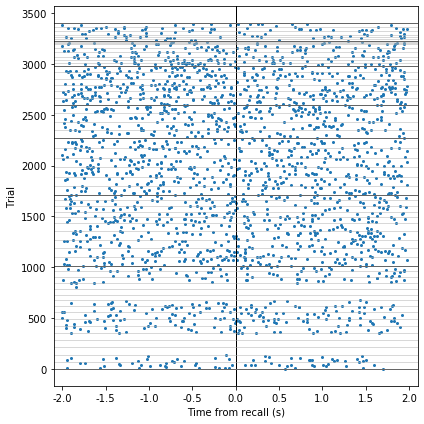

In [384]:
# for the raster and PSTH binarize the data by using the start indices of the ripple
%autoreload
sr = 500 # fixed at this value since this is the minimum across data and can always downsample
sr_factor = (1000/sr)
start_array = np.zeros((ripple_array.shape))
end_array = np.zeros((ripple_array.shape))
num_trials = ripple_array.shape[0]
for trial in range(num_trials):
    ripplelogictrial = ripple_array[trial]
    starts,ends = getLogicalChunks(ripplelogictrial)
    temp_row = np.zeros(len(ripplelogictrial))
    temp_row[starts] = 1
    start_array[trial] = temp_row # time when each SWR starts
    temp_row = np.zeros(len(ripplelogictrial))
    temp_row[ends] = 1
    end_array[trial] = temp_row

# plot raster
subplots(1,1,figsize=(6,6))    
scatter(np.where(start_array)[1]*sr_factor+start,np.where(start_array)[0],s=4) # SWR time v. trial
xticks(np.arange(start,end+1,500),np.arange(start/1000,end/1000+1,0.5))
xlabel('Time from recall (s)')
ylabel('Trial')
tight_layout()
ax = plt.gca()
ax.set_xlim(start-100,end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))
last_sub = sub_names[0]
for s in range(1,len(trial_nums)):
    if sub_names[s] != last_sub:
        plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
        last_sub = sub_names[s]
    else: # plot gray line between sessions
        plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.7,.7,.7))
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
ax.autoscale(enable=True, axis='y', tight=True)
print('Total FR events: '+str(total_recalls))
print('Kept FR events: '+str(kept_recalls))
print(start_array.shape);

In [396]:
# make a PSTH based on start times of SWRs
binsize = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = smoothing_triangle-3 # factor is how many points from middle does triangle go?

PSTH,bin_centers = fullPSTH(start_array,binsize,smoothing_triangle,sr,start)
# bootstraps error bars by sampling from trials in raster with replacement samples number of
# times and then taking the standard deviation across those samples
boot_samples = bootstrap(start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
               bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,start))
boot_SD = np.std(boot_samples,0)

# create a resampling surrogate to probe chance and do cluster stats
# the surrogate is samples number of PSTHs where the num of ripples kept constant
# in each trial but the times were randomly shifted in those trials
nbins = int(np.ceil(start_array.shape[1]/binsize))
shuffledRate = np.zeros((nbins,samples))
realRate = PSTH
samples = 100
num_trials = start_array.shape[0]
time_length = start_array.shape[1]
shuffledRate = []
for i in range(samples):
    # get list of trials with replacement and the number of ripples within them
    rip_ct = np.sum(start_array,1)
    permdata = np.zeros(np.shape(start_array))
    for trial in range(num_trials):
        if rip_ct[trial]>0:
            rand_times = randint(0,time_length,int(rip_ct[trial])) # randomize rip times w/in each trial
            permdata[trial,rand_times] = 1 # so each trial always has same # of SWRs
    permPSTH,_ = fullPSTH(permdata,binsize,smoothing_triangle,sr,start)        
    shuffledRate = superVstack(shuffledRate,permPSTH) # sample X bins
shuffledRate = shuffledRate[:,pad:-pad] # remove padded sides
mean_shuffled_rate = np.mean(shuffledRate)
shuffled_std = np.std(shuffledRate)

# find significant clusters
cluster_thresh = 1.96
# get lower and upper 1.96 SD thresholds
thresh = [mean_shuffled_rate-(cluster_thresh*shuffled_std),mean_shuffled_rate+(cluster_thresh*shuffled_std)]
max_clusts = []
for i in range(samples):
    temp = (shuffledRate[i]<thresh[0]) | (shuffledRate[i]>thresh[1]) 
    starts,ends = getLogicalChunks(temp)
    if len(starts)>0:
        temp_clust = (np.array(ends)-np.array(starts))+1 # length of each cluster
        max_clusts.append(np.max(temp_clust)) # longest cluster
    else: max_clusts.append(0)
# actual data
real_thresh_crosses = (realRate<thresh[0]) | (realRate>thresh[1])
starts,ends = getLogicalChunks(real_thresh_crosses)
real_clust = (np.array(ends)-np.array(starts))+1;

In [397]:
binsize
bin_centers

100

array([-1950., -1850., -1750., -1650., -1550., -1450., -1350., -1250.,
       -1150., -1050.,  -950.,  -850.,  -750.,  -650.,  -550.,  -450.,
        -350.,  -250.,  -150.,   -50.,    50.,   150.,   250.,   350.,
         450.,   550.,   650.,   750.,   850.,   950.,  1050.,  1150.,
        1250.,  1350.,  1450.,  1550.,  1650.,  1750.,  1850.,  1950.])

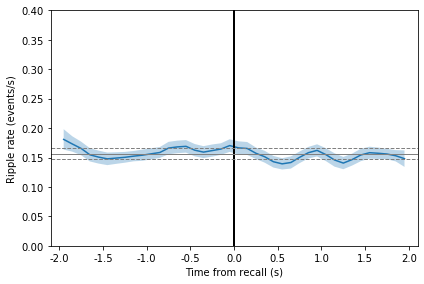

In [398]:
sig_mask = np.zeros(len(temp)) # get locations of significant clusters
clusterPval = []
if sum(real_thresh_crosses)>0:
    real_starts,_ = getLogicalChunks(real_thresh_crosses) # number of actual crosses is starts
    for k in range(len(real_starts)): 
        clusterPval.append( (np.sum(max_clusts>real_clust[k])+1) / (samples+1))
        if clusterPval[k]<0.05:
            sig_mask[starts[k]:ends[k]+1]=1
    max_cluster_actual_data = np.max(real_clust)
    # convert significant clsuters to bins
    clust_start,clust_end = getLogicalChunks(sig_mask)
    sig_clust_ranges = []
    for cl in range(len(clust_start)):
        sig_bins = bin_centers[clust_start[cl]:clust_end[cl]+1] # get sig. bins and create xvalues for a line
        sig_clust_ranges.append([np.min(sig_bins)-binsize/2,np.max(sig_bins)+binsize/2])

# plot PSTH
subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(start,end,binsize)
#plot(xr,norm_count[0]) # actual data
plot(xr,PSTH)
fill_between(xr, PSTH+boot_SD, PSTH-boot_SD, alpha = 0.3)
# bootstrap SE using random sample with replacement

xticks(np.arange(start,end+1,500),np.arange(start/1000,end/1000+1,500/1000))
xlabel('Time from recall (s)')
ylabel('Ripple rate (events/s)')
tight_layout()
ax = plt.gca()
ax.set_ylim(0,0.4)
ax.set_xlim(start-100,end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=2,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]
plot(x_width,list(mean_shuffled_rate*np.ones(2)),linewidth=1,color=(0.5,0.5,0.5));
plot(x_width,list((mean_shuffled_rate+shuffled_std)*np.ones(2)),linewidth=1,linestyle='--',color=(0.5,0.5,0.5));
plot(x_width,list((mean_shuffled_rate-shuffled_std)*np.ones(2)),linewidth=1,linestyle='--',color=(0.5,0.5,0.5));
# if len(sig_clust_ranges)>0:
#     for cl in range(len(sig_clust_ranges)):
#         plot(sig_clust_ranges[cl],[0.45,0.45],color=(1,0.7,0.23),linewidth=3)
#         print('Cluster p-value: '+str(clusterPval[cl]))
# else: print('Largest cluster p-value is: '+str(clusterPval[0]))
a=1;

In [296]:
trial_nums
trial_nums[0] # if looking at first session from first subject this many trials
ripple_array.shape # all trials
start_array.shape
eeg.shape
evs_free_recall.shape
electrodes_per_session
np.sum(trial_nums[:2])
trial_ct
array_trial_offset

array([43., 43., 43., 43., 43., 43., 43., 43., 36., 36., 36., 36., 36.,
       36., 36., 36., 49., 49., 49., 49., 49., 38., 38., 38., 38., 38.,
       51., 51., 51., 47., 47., 47., 57., 57., 57., 57., 44., 44., 44.,
       40., 40., 40., 22., 22., 22., 28., 28., 28., 10., 10., 10.])

43.0

(2021, 3500)

(2021, 3500)

(43, 72, 3500)

(43, 21)

array([8., 8., 5., 5., 3., 3., 4., 3., 3., 3., 3., 3.])

86.0

0.0

0.0

In [313]:
# example of butterworth v. FIR filters
num,den = butter(2,[70/250,180/250],btype='band') # Butterworth filter 
eeg_filtered_butter = filtfilt(num,den,eeg_ptsa)
FIR_filter = firwin(int(ntaps+1), [70.,180.], fs=500, window='hamming')
eeg_filtered = eeg_ptsa - filtfilt(FIR_filter,1.,eeg_ptsa) 

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1001P/localizations/0/montages/0/neuroradiology/current_processed/pairs.json
/data/eeg/R1001P/tal/R1001P_talLocs_database_bipol.mat returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/readers/tal.py:43: FutureWarning: Lab-specific readers may be moved to the cmlreaders package (https://github.com/pennmem/cmlreaders)
  FutureWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/cmlreaders/path_finder.py:239: MultiplePathsFoundWarning: Multiple files found: /protocols/r1/subjects/R1001P/experiments/FR1/sessions/0/ephys/current_processed/sources.json
/data/eeg/R1001P/eeg.noreref/params.txt returning the first file found
  warnings.warn(msg, MultiplePathsFoundWarning)
/home1/john/anaconda3/envs/env1/lib/python3.7/site-

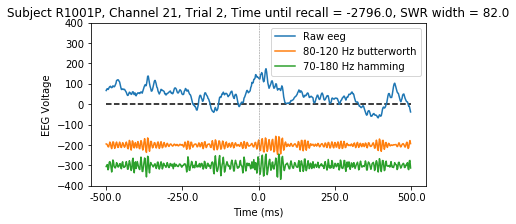

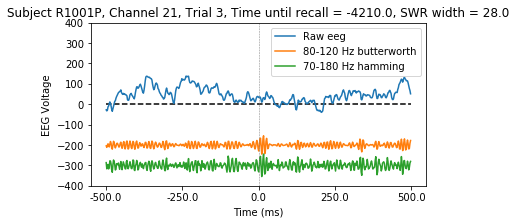

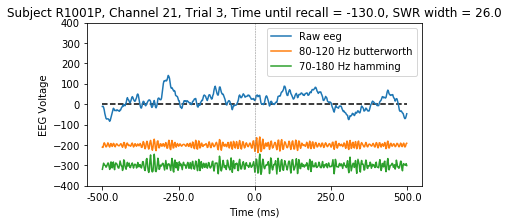

In [324]:
# let's look at some of these SWR events! 

# Need to run top eeg load first to get start_array and sr.
# start_array is recall_events X time with binary 1 for start of each detected SWR

%autoreload
from ptsa.data.filters import ButterworthFilter
from scipy.signal import firwin,filtfilt

which_session = 0 # select from the df
first_trial = 0
trials_to_print = 5 # note: will skip trials with no ripples

sample_rate = 500.
trans_width = 5.
ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sample_rate/trans_width)
FIR_filter = firwin(int(ntaps+1), [70.,180.], fs=500, window='hamming')
bb,aa = butter(2,[70/250,180/250],btype='band') # Butterworth test filter

temp_sub_df = sub_df[0:which_session+1] 
array_trial_offset = int(np.sum(trial_nums[:which_session]))
temp_sub_df

pre_rip = -500 # plots this many ms before and after the ripple
post_rip = 500

ymin = -400 #np.min(stim_eeg[trial,:])
ymax = 400 #np.max(stim_eeg[trial,:])
display_mult = 5 # increase 80-120 Hz by this factor to see it better on graph
y_offset = -200 # move 80-120 filtered band down for visualization purposes

xr = np.arange(0,(post_rip-pre_rip)/sr_factor)
yr = np.arange(ymin,ymax)
num_ripples = np.sum(start_array)

trial_ct = 0
for row in temp_sub_df.itertuples():
    # get bipolar pairs
    sub = row.subject; mont = int(row.montage); loc = int(row.localization)
    exp = row.experiment; session = int(row.session)
    reader = CMLReadDFRow(row)
    evs = reader.load('task_events')
    pairs = reader.load('pairs')
    evs_free_recall = evs[evs.type=='REC_WORD']
    # remove events with Inter-Recall Intervals too small. Use start time since that's what will show in PSTH
    evs_free_recall = evs_free_recall[np.append(True,np.diff(evs_free_recall.mstime)>IRI)] #abs(start))]
    tal_struct, bipolar_pairs, mpchans = get_bp_tal_struct(sub, montage=mont, localization=loc)
    elec_regions,_ = get_elec_regions(tal_struct)      
    
    eeg = reader.load_eeg(events=evs_free_recall, rel_start=start, rel_stop=end, clean=True, scheme=pairs)
    eeg_ptsa = eeg.to_ptsa()
    eeg_ptsa = eeg_ptsa.baseline_corrected((start,end))
    eeg_vaz = eeg_ptsa.filtered([80.,120.], filt_type='bandpass', order=2) # Butterworth 2nd order a la Vaz/Zaghloul
    eeg_norman = filtfilt(FIR_filter,1.,eeg_ptsa) 
#     eeg_butter_70180 = filtfilt(bb,aa,eeg_ptsa) # test Butterworth with 70-180 Hz...like combining two methods
#     eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
    
    for channel in range(len(elec_regions)):
        if elec_regions[channel] in HPC_labels:
            for trial in range(len(evs_free_recall)): # maximum trials is # elecs * recall_events
                if trial_ct >= (first_trial) and trial_ct<(first_trial+trials_to_print):
                    if np.sum(start_array[trial_ct+array_trial_offset])>0: # if there is a ripple in this trial
                        rip_times = (np.array(np.where(start_array[trial_ct]))*sr_factor)[0] # convert to ms
                        rip_lengths = ((sr_factor*np.array(np.where(end_array[trial_ct])))-rip_times)[0]
                        for rip in range(len(rip_times)): # get each ripple 
                            rip_time = rip_times[rip]
                            rip_length = rip_lengths[rip]
                            #print(str(rip_time+start))
                            # note: any time dealing with eeg, need to account for sampling rate (see all the sr_factors)
                            if rip_time>abs(pre_rip) and rip_time<(eeg_ptsa.shape[2]*sr_factor-abs(post_rip)): # if enough time before/after ripple to plot
                                stim_eeg = eeg_ptsa[trial_ct,channel,int((rip_time+pre_rip)/sr_factor):int((rip_time+post_rip)/sr_factor)]
                                filt_eeg_vaz = eeg_vaz[trial_ct,channel,int((rip_time+pre_rip)/sr_factor): # eeg_butter_70180
                                                                int((rip_time+post_rip)/sr_factor)]
                                filt_eeg_norman = stim_eeg - eeg_norman[trial_ct,channel,int((rip_time+pre_rip)/sr_factor):
                                                             int((rip_time+post_rip)/sr_factor)]
                                
                                plt.figure(figsize=(6, 3)) 
                                ax = plt.subplot(111)
                                plt.plot(xr,stim_eeg)
                                plt.plot(xr,display_mult*filt_eeg_vaz+y_offset)
                                plt.plot(xr,display_mult*filt_eeg_norman+y_offset*3/2)
                                plt.ylabel('EEG Voltage'); plt.xlabel('Time (ms)')
                                plt.plot(abs(pre_rip/sr_factor)*np.ones(len(yr)),yr,marker='',linewidth=0.5,linestyle='--',color=[0.5,0.5,0.5])
                                plt.legend(['Raw eeg','80-120 Hz butterworth','70-180 Hz hamming']) 
                                plt.title('Subject '+sub+', Channel '+str(channel)+', Trial '+str(trial_ct)+', Time until recall = '
                                          +str(rip_time+start)+', SWR width = '+str(rip_length))
                                plt.xticks(np.arange(0,post_rip-pre_rip+1,post_rip/4),np.arange(pre_rip,post_rip+1,post_rip/2))
                                ax.set_ylim([ymin,ymax])
                                plt.hlines(0,xr[0],xr[-1], linestyle='--', color='k')
                trial_ct+=1 # keep track of which trial we're on out of total ELEC X RECALL trials
a=1;

### rip_lengths[0]

In [89]:
## NEVERMIND. Do it based on ISI of recall times, NOT ripple times. That's actually what Norman et al did.
# # Now that we have a start_array with all ripples, need to check ISIs to make sure
# # we're not double-dipping on recall events. For example, if two recall events
# # are only 500 ms apart, we don't want to put the same ripple in the PSTH twice just 500 ms apart
# # remove duplicate ripples < this interripple interval (IRI) time.
# IRI_thresh = abs(start) # Setting to start (PSTH beginning time) makes sense for PSTH
# ripple_idxs = np.where(ripple_mstime_array)
# ripple_abs_times = ripple_mstime_array[ripple_idxs]
# IRIs = np.diff(ripple_abs_times) # inter-ripple intervals
# 
# # this looks at current IRI and cumulative IRIs and eliminates everything but first one
# for rip in range(len(IRIs)): # for each ripple, check if next ripples are within IRI_thresh
#     if IRIs[rip]<=IRI_thresh:
#         # find how many into future are <=IRI_thresh
#         next_rip = 1
#         while np.sum(IRIs[rip:rip+next_rip])<=IRI_thresh:            
#             next_rip+=1
#             if (rip+next_rip)>=len(IRIs):
#                 break
#         # now you know how many ripples to remove
#         IRIs[rip:rip+next_rip-1] = Inf # so it won't be caught again in next step of for loop
#          # +1 below because used diff so always removing ripples after 1st
#         start_array[ripple_idxs[0][rip+1:rip+1+next_rip],ripple_idxs[1][rip+1:rip+1+next_rip]] = 0
#         # note: end_array can be left alone, since it's only indexed after finding a ripple from start_array

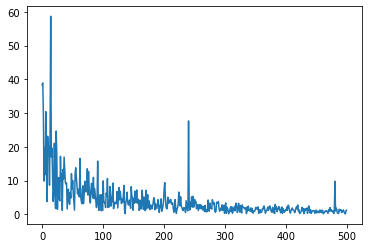

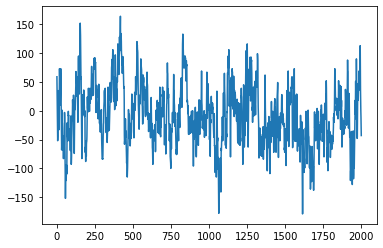

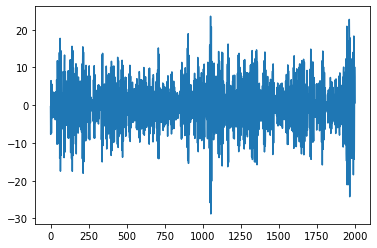

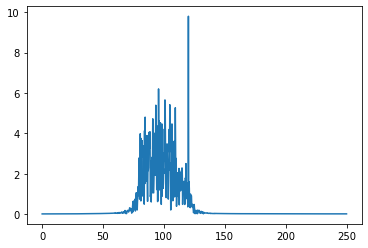

In [482]:
# example fft plot from https://intellipaat.com/community/32125/plotting-a-fast-fourier-transform-in-python
from scipy import fft 

N = 1000 # Number of samplepoints 
T = 1.0 / N # sample spacing 
x = np.linspace(0.0, N*T, N) 

# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
y = temp
filt80120 = temp.filtered([80,120],order=4,filt_type='bandpass')

yf = fft(y) 
xf = np.linspace(0.0, N/2, N/2) 
fig,ax = plt.subplots() 
ax.plot(xf, 2.0/N * np.abs(yf[:N//2])) 
plt.show()

plt.plot(y)
plt.show()
plt.plot(z)
plt.show()

fft_filt80120 = fft(filt80120)
NN = len(filt80120)
xff = np.linspace(0,NN/8,NN/2) # I think this is 4000 ms/500 SR to get 8
plt.plot(xff,8/NN*np.abs(fft_filt80120[:NN//2]))